# **SETUP**

---

In [1]:
%pip install -q pytorch-lightning torchmetrics wandb

import os
import random
from typing import List, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import wandb
from kaggle_secrets import UserSecretsClient
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from sklearn.metrics import accuracy_score, confusion_matrix, jaccard_score
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics import Accuracy, ConfusionMatrix, JaccardIndex
from torchvision import transforms
from torchvision.transforms import transforms
from tqdm import tqdm


# Log into Wandb
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb-key")
!wandb login $wandb_key

Note: you may need to restart the kernel to use updated packages.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **DATASET**

---

In [2]:
class AI4MARSDataset(Dataset):
    def __init__(self, images_path: str, masks_path: str, dataset_size: int = 500):
        self.images_path = images_path
        self.masks_path = masks_path
        self.dataset_size = dataset_size
        
        images = set(os.listdir(images_path))
        self.masks = [mask for mask in os.listdir(masks_path) if mask[:-4] + ".JPG" in images][:dataset_size]

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        mask_name = self.masks[idx]

        image_path = os.path.join(self.images_path, mask_name[:-4] + ".JPG")
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        image = np.asarray(image, dtype=np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))  # Change the order of dimensions to (C, H, W)
        image = torch.from_numpy(image)

        mask_path = os.path.join(self.masks_path, mask_name)
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)
        mask = np.array(mask, dtype=np.uint8)
        mask[mask == 255] = 4
        mask = torch.from_numpy(mask)
        mask = mask.long()

        return image, mask

class AI4MARSDataModule(pl.LightningDataModule):
    def __init__(self, images_path: str, masks_path: str, dataset_size: int = 5000, batch_size: int = 32, num_workers: int = 4):
        super().__init__()
        self.images_path = images_path
        self.masks_path = masks_path
        self.dataset_size = dataset_size
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.dataset = AI4MARSDataset(self.images_path, self.masks_path, self.dataset_size)

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, pin_memory=True)

# **MODEL**

---

In [3]:
class ImageSegmentationModel(pl.LightningModule):
    def __init__(self, num_classes: int = 5, learning_rate: float = 1e-4):
        super().__init__()

        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.num_classes = num_classes

        self.model_weights = torchvision.models.segmentation.FCN_ResNet50_Weights.DEFAULT
        self.model = torchvision.models.segmentation.fcn_resnet50(weights=self.model_weights)
        self.model.classifier[-1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))

        self.loss = nn.CrossEntropyLoss()
        self.confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=num_classes)
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.iou = JaccardIndex(task='multiclass', num_classes=num_classes)

    def forward(self, x):
        return self.model(x)['out']

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss(preds, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss(preds, y)
        preds = torch.argmax(preds, dim=1)

        # Log metrics
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_acc', self.accuracy(preds, y), on_step=True, on_epoch=True)
        self.log('val_iou', self.iou(preds, y), on_step=True, on_epoch=True)

# **TRAINING**

---

In [4]:
def train_single_run(data_module: AI4MARSDataModule, epochs: int = 10):

    # Split the dataset into training and validation sets
    dataset_size = len(data_module.dataset)
    train_size = int(dataset_size * 0.8)
    val_size = dataset_size - train_size
    train_dataset, val_dataset = random_split(data_module.dataset, [train_size, val_size])

    # Set up data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=data_module.batch_size, shuffle=True, num_workers=data_module.num_workers)
    val_dataloader = DataLoader(val_dataset, batch_size=data_module.batch_size, num_workers=data_module.num_workers)

    # Initialize the Lightning model
    model = ImageSegmentationModel()

    # Set up Weights & Biases logger
    wandb_logger = pl.loggers.WandbLogger(name="AI4MARS_single_run", project="AI4MARS")

    # Set up checkpoint callback
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints",
        filename="checkpoint-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        mode="min",
    )

    # Set up the Lightning trainer
    trainer = pl.Trainer(logger=wandb_logger, max_epochs=epochs, accelerator='gpu', devices=-1, callbacks=[checkpoint_callback], log_every_n_steps=50)

    # Train and validate the model
    trainer.fit(model, train_dataloader, val_dataloader)
    
    # Save the model checkpoint after training
    torch.save(model.state_dict(), "trained_model_checkpoint.pth")

    # End current run
    wandb.finish()
    
    # Return summary
    return wandb_logger.experiment.summary

# **EXECUTION**

---

In [25]:
# Paths
IMAGES_PATH = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/images/edr"
MASK_PATH_TRAIN = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/labels/train"
MASK_PATH_TEST = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/labels/test/masked-gold-min1-100agree/"

# Hyperparameters
DATASET_SIZE = 15000
BATCH_SIZE = 32
EPOCHS = 25

In [19]:
# Load dataset
rock_data = AI4MARSDataModule(IMAGES_PATH, MASK_PATH_TRAIN, dataset_size=DATASET_SIZE, batch_size=BATCH_SIZE, num_workers=2)
rock_data.setup()

# Train model
# summary = train_single_run(rock_data, epochs=EPOCHS)

# **DEMONSTRATION**

---

In [26]:
# Preprocess images
def preprocess_image(image_path: str, return_tensor: bool = False):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image_normalized = np.asarray(image, dtype=np.float32) / 255.0
    
    if return_tensor:
        image_normalized = np.transpose(image_normalized, (2, 0, 1))
        image_tensor = torch.from_numpy(image_normalized).unsqueeze(0)
        return image, image_tensor
    
    return image

# Preprocess masks
def preprocess_mask(mask_path: str):
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)
    mask[mask == 255] = 4
    return mask

# Find an image in the test set
def display_segmentation(index):
    mask_files = [filename for filename in os.listdir(MASK_PATH_TEST) if filename.endswith("_merged.png")]
    test_image_name = mask_files[index][:-11] + ".JPG"

    # Load the test image
    test_image_path = os.path.join(IMAGES_PATH, test_image_name)
    test_image, test_image_tensor = preprocess_image(test_image_path, return_tensor=True)
    test_image_tensor = test_image_tensor.to(device)

    # Perform prediction
    with torch.no_grad():
        prediction = model(test_image_tensor)
        predicted_mask = torch.argmax(prediction, dim=1).squeeze().cpu().numpy()

    # Load the ground truth segmentation
    ground_truth_mask_path = os.path.join(MASK_PATH_TEST, test_image_name[:-4] + "_merged.png")
    ground_truth_mask = preprocess_mask(ground_truth_mask_path)

    return test_image, ground_truth_mask, predicted_mask

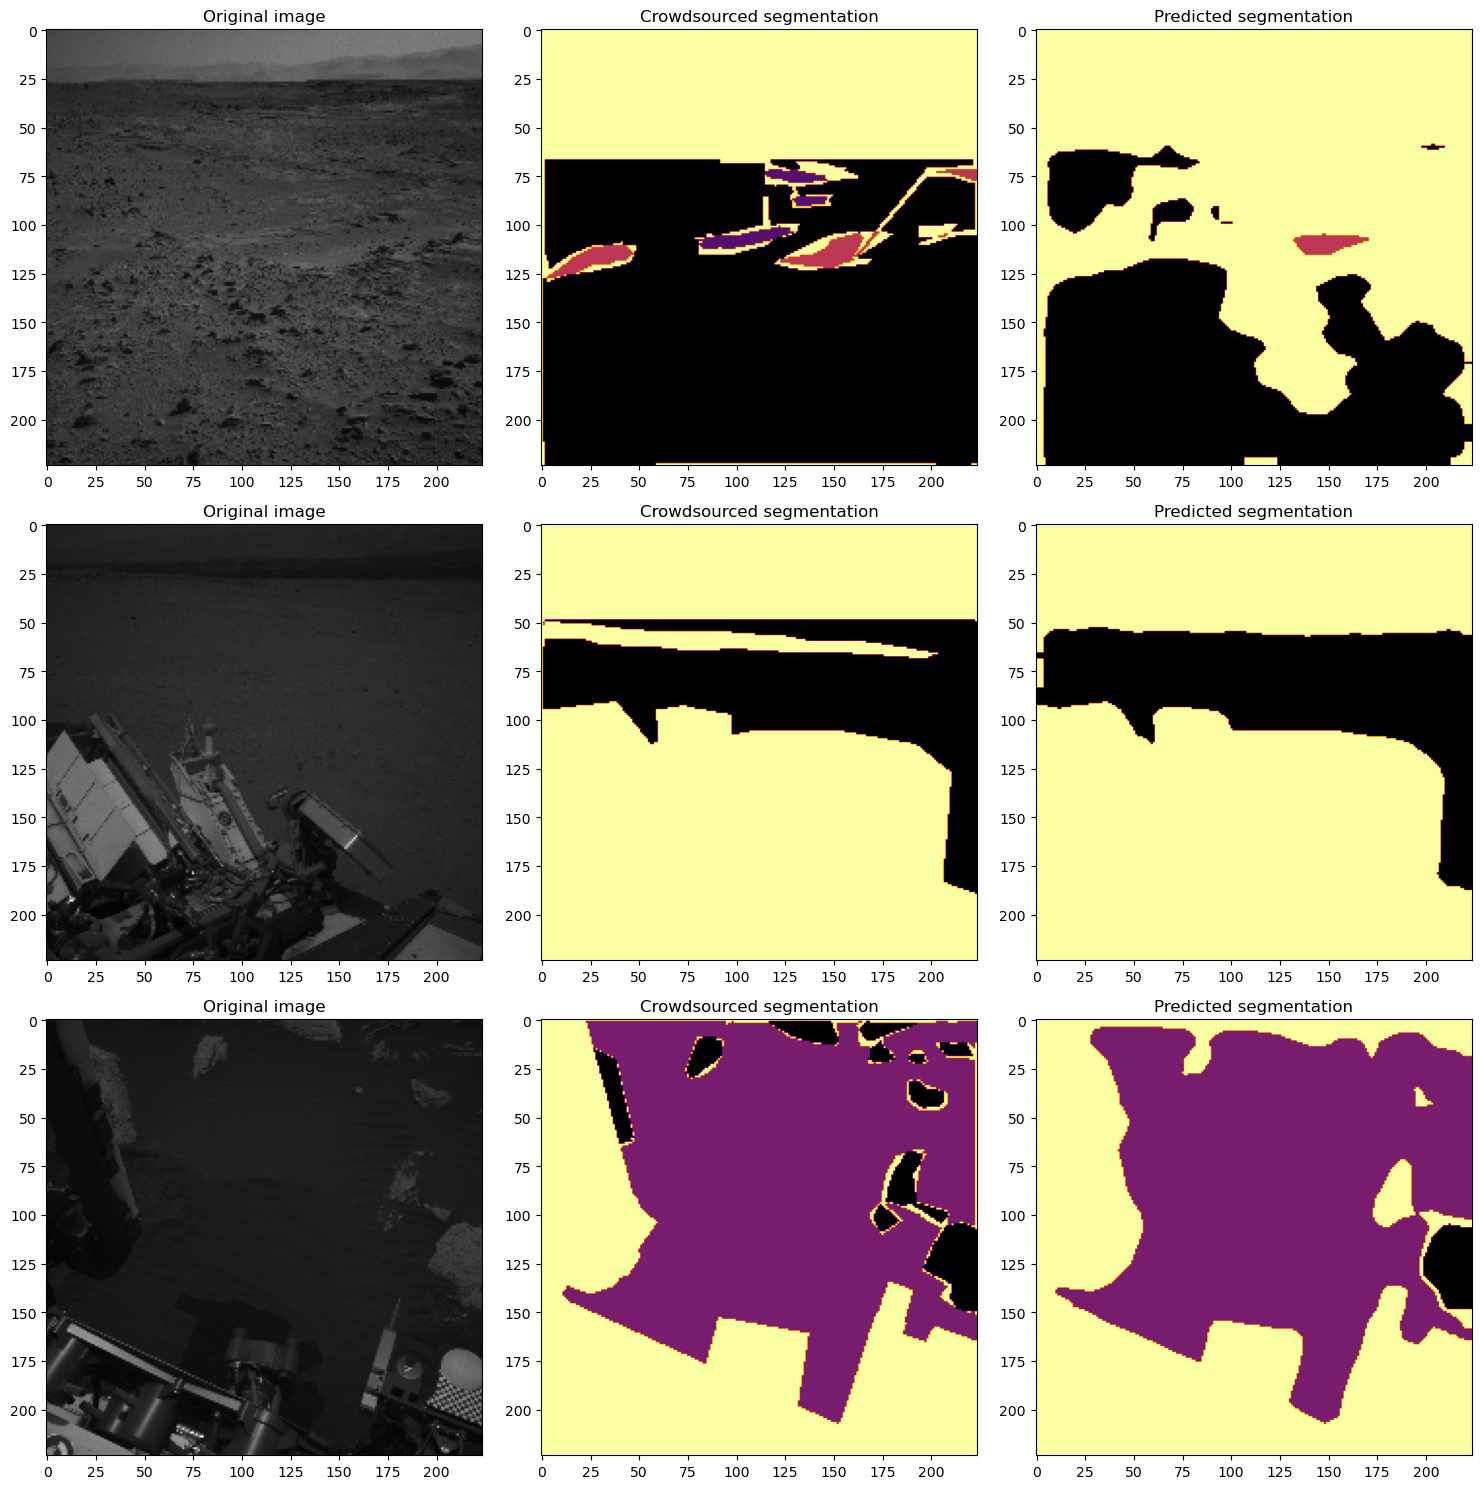

In [27]:
# Choose device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the saved model
model = ImageSegmentationModel()
model.load_state_dict(torch.load("/kaggle/input/checkpoints/trained_model_checkpoint.pth"))
model.eval()
model.to(device)

# Choose indices
indices = [11, 12, 16]
segmentations = [display_segmentation(index) for index in indices]

# Plot the images
fig, axes = plt.subplots(len(indices), 3, figsize=(15, 15))
for i, (test_image, ground_truth_mask, predicted_mask) in enumerate(segmentations):
    axes[i, 0].imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title("Original image")
    axes[i, 1].imshow(ground_truth_mask, cmap="inferno")
    axes[i, 1].set_title("Crowdsourced segmentation")
    axes[i, 2].imshow(predicted_mask, cmap="inferno")
    axes[i, 2].set_title("Predicted segmentation")

plt.tight_layout()
plt.show()

# **EVALUATION**

---

In [28]:
class TestDataset(Dataset):
    def __init__(self, images_path: str, masks_path: str):
        self.images_path = images_path
        self.masks_path = masks_path
        self.mask_files = [mask for mask in os.listdir(masks_path) if mask.endswith("_merged.png")]

    def __len__(self):
        return len(self.mask_files)

    def __getitem__(self, idx):
        mask_name = self.mask_files[idx]
        image_name = mask_name[:-11] + ".JPG"

        image_path = os.path.join(self.images_path, image_name)
        _, image_tensor = preprocess_image(image_path, return_tensor=True)

        mask_path = os.path.join(self.masks_path, mask_name)
        mask = preprocess_mask(mask_path)

        # Remove the extra dimension
        image_tensor = image_tensor.squeeze(0)

        return image_tensor, mask

In [29]:
def evaluate_test_set(model, images_path, masks_path, batch_size=32, num_workers=2, device='cuda'):
    
    # Load dataloaders
    test_dataset = TestDataset(images_path, masks_path)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

    # Initialize arrays for storing ground truth and predictions
    ground_truths = []
    predictions = []

    for batch_images, batch_masks in tqdm(test_dataloader):
        # Move the images to the GPU
        batch_images = batch_images.to(device)

        # Perform prediction
        with torch.no_grad():
            batch_prediction = model(batch_images)
            batch_predicted_masks = torch.argmax(batch_prediction, dim=1).cpu().numpy()

        # Flatten and append the ground truth and predictions
        ground_truths.extend([mask.flatten() for mask in batch_masks])
        predictions.extend([mask.flatten() for mask in batch_predicted_masks])

    # Compute accuracy
    accuracy = accuracy_score(np.concatenate(ground_truths), np.concatenate(predictions))

    # Compute IoU (Jaccard score)
    iou = jaccard_score(np.concatenate(ground_truths), np.concatenate(predictions), average="weighted")

    # Compute confusion matrix
    cm = confusion_matrix(np.concatenate(ground_truths), np.concatenate(predictions))
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    return accuracy, iou, cm_normalized

100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


Accuracy: 0.8451
IoU: 0.7360


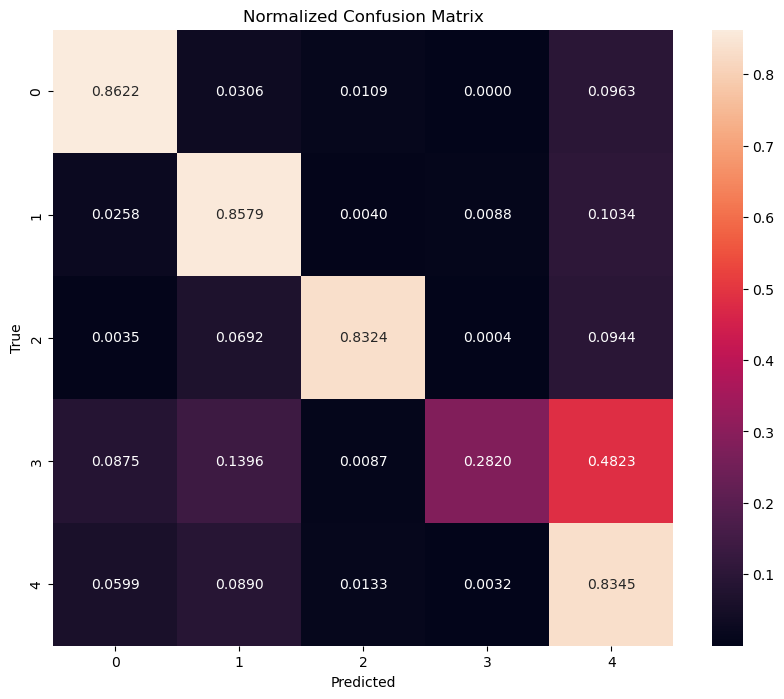

In [30]:
# Evaluate the model
accuracy, iou, cm_normalized = evaluate_test_set(model, IMAGES_PATH, MASK_PATH_TEST, device=device)
print(f"Accuracy: {accuracy:.4f}")
print(f"IoU: {iou:.4f}")

# Plot the normalized confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".4f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()